In [1]:
!pip install -q pyspark


from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window


spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext

In [2]:
customers_data = [
(1, "Rahul Sharma", "Bangalore", 28),
(2, "Priya Singh", "Delhi", 32),
(3, "Aman Kumar", "Hyderabad", 25),
(4, "Sneha Reddy", "Chennai", 35),
(5, "Arjun Mehta", "Mumbai", 30),
(6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

In [3]:
products_data = [
(101, "Laptop", "Electronics", 55000),
(102, "Mobile", "Electronics", 25000),
(103, "Headphones", "Electronics", 3000),
(104, "Chair", "Furniture", 5000),
(105, "Book", "Stationery", 700),
(106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

In [4]:


orders_data = [
(1001, 1, 101, 1, "2024-01-10"),
(1002, 2, 102, 2, "2024-01-12"),
(1003, 1, 103, 3, "2024-02-05"),
(1004, 3, 104, 1, "2024-02-08"),
(1005, 5, 105, 5, "2024-03-01"),
(1006, 6, 106, 2, "2024-03-15"),
(1007, 7, 101, 1, "2024-03-20")
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)


print("Data prepared.\n")

Data prepared.



In [5]:
nums = [10,20,30,40,50]
nums_rdd = sc.parallelize(nums)
print("Sum:", nums_rdd.sum())
print("Max:", nums_rdd.max())
print("Min:", nums_rdd.min())
print("Average:", nums_rdd.mean())


sentences = ["Spark is fast", "Spark is powerful", "Big data is huge"]
sentences_rdd = sc.parallelize(sentences)
words_rdd = sentences_rdd.flatMap(lambda x: x.split(" "))
word_count = words_rdd.map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b)
print("Word count:")
print(word_count.collect())

Sum: 150
Max: 50
Min: 10
Average: 30.0
Word count:
[('fast', 1), ('powerful', 1), ('Big', 1), ('huge', 1), ('Spark', 2), ('is', 3), ('data', 1)]


In [6]:
print("Customer names and cities:")
customers_df.select("name","city").show()


print("Customers older than 30:")
customers_df.filter(F.col("age")>30).show()


print("Distinct product categories:")
products_df.select("category").distinct().show()


print("Top 3 most expensive products:")
products_df.orderBy(F.desc("price")).limit(3).show()

Customer names and cities:
+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

Customers older than 30:
+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+

Distinct product categories:
+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+

Top 3 most expensive products:
+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+------

In [7]:
print("Average age of customers per city:")
customers_df.groupBy("city").agg(F.round(F.avg("age"),2).alias("avg_age")).show()


print("Total revenue per product:")
revenue_per_product = orders_df.join(products_df, "product_id", "left").withColumn("revenue", F.col("quantity")*F.col("price"))
revenue_per_product.groupBy("product_id","product_name").agg(F.sum("revenue").alias("total_revenue")).show()


print("Most popular product by quantity sold:")
orders_df.groupBy("product_id").agg(F.sum("quantity").alias("total_qty")).join(products_df,"product_id").orderBy(F.desc("total_qty")).limit(1).show()

Average age of customers per city:
+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+

Total revenue per product:
+----------+------------+-------------+
|product_id|product_name|total_revenue|
+----------+------------+-------------+
|       103|  Headphones|         9000|
|       101|      Laptop|       110000|
|       102|      Mobile|        50000|
|       104|       Chair|         5000|
|       106|       Shoes|         5000|
|       105|        Book|         3500|
+----------+------------+-------------+

Most popular product by quantity sold:
+----------+---------+------------+----------+-----+
|product_id|total_qty|product_name|  category|price|
+----------+---------+------------+----------+-----+
|       105|        5|        Book|Stationery|  700|
+----------+---------+------------+----------+-----+



In [8]:
print("Customers with purchases:")
customers_df.join(orders_df, "customer_id", "inner").show()


print("Order details with product info:")
orders_df.join(products_df, "product_id", "left").select("order_id","product_name","category","quantity","order_date").show()


print("Customers who never placed an order:")
customers_df.join(orders_df, "customer_id", "left_anti").show()


print("Products never ordered:")
products_df.join(orders_df, "product_id", "left_anti").show()

Customers with purchases:
+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+---------+---+--------+----------+--------+----------+
|          1|Rahul Sharma|Bangalore| 28|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|Bangalore| 28|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    Delhi| 32|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|Hyderabad| 25|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|   Mumbai| 30|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    Delhi| 29|    1006|       106|       2|2024-03-15|
+-----------+------------+---------+---+--------+----------+--------+----------+

Order details with product info:
+--------+------------+-----------+--------+----------+
|order_id|product_name|   category|quantity|order_date|
+--------+--------

In [9]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")


print("Top 2 cities by total revenue:")
q1 = spark.sql("""
SELECT c.city, SUM(o.quantity*p.price) AS revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.city
ORDER BY revenue DESC
LIMIT 2
""")
q1.show()


print("Customers who spent more than 50,000:")
q2 = spark.sql("""
SELECT c.customer_id, c.name, SUM(o.quantity*p.price) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.customer_id, c.name
HAVING total_spent > 50000
""")
q2.show()


print("Best-selling product category by revenue:")
q3 = spark.sql("""
SELECT p.category, SUM(o.quantity*p.price) AS revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC
LIMIT 1
""")
q3.show()

Top 2 cities by total revenue:
+---------+-------+
|     city|revenue|
+---------+-------+
|Bangalore|  64000|
|    Delhi|  55000|
+---------+-------+

Customers who spent more than 50,000:
+-----------+------------+-----------+
|customer_id|        name|total_spent|
+-----------+------------+-----------+
|          1|Rahul Sharma|      64000|
+-----------+------------+-----------+

Best-selling product category by revenue:
+-----------+-------+
|   category|revenue|
+-----------+-------+
|Electronics| 169000|
+-----------+-------+



In [10]:
orders_csv_path = "/content/orders_output_csv"
orders_df.write.mode("overwrite").option("header",True).csv(orders_csv_path)
print(f"Orders saved to {orders_csv_path}")
orders_loaded = spark.read.option("header",True).csv(orders_csv_path)
orders_loaded.show()


products_json_path = "/content/products_output_json"
products_df.write.mode("overwrite").json(products_json_path)
products_loaded = spark.read.json(products_json_path)
products_loaded.show()

Orders saved to /content/orders_output_csv
+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+--------+-----------+----------+--------+----------+
|    1004|          3|       104|       1|2024-02-08|
|    1005|          5|       105|       5|2024-03-01|
|    1006|          6|       106|       2|2024-03-15|
|    1007|          7|       101|       1|2024-03-20|
|    1001|          1|       101|       1|2024-01-10|
|    1002|          2|       102|       2|2024-01-12|
|    1003|          1|       103|       3|2024-02-05|
+--------+-----------+----------+--------+----------+

+-----------+-----+----------+------------+
|   category|price|product_id|product_name|
+-----------+-----+----------+------------+
|Electronics|55000|       101|      Laptop|
|Electronics|25000|       102|      Mobile|
|Electronics| 3000|       103|  Headphones|
|  Furniture| 5000|       104|       Chair|
| Stationery|  700|       105|        Book|
|    Fashi

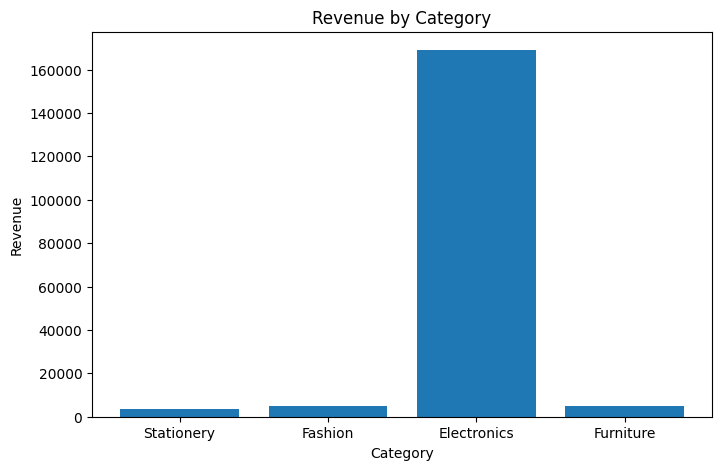

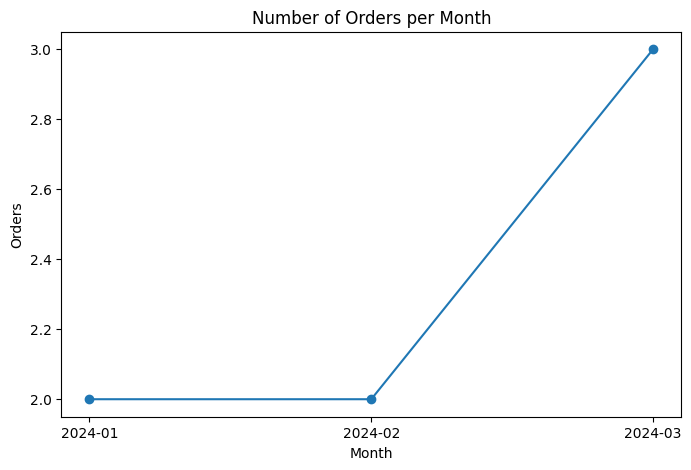

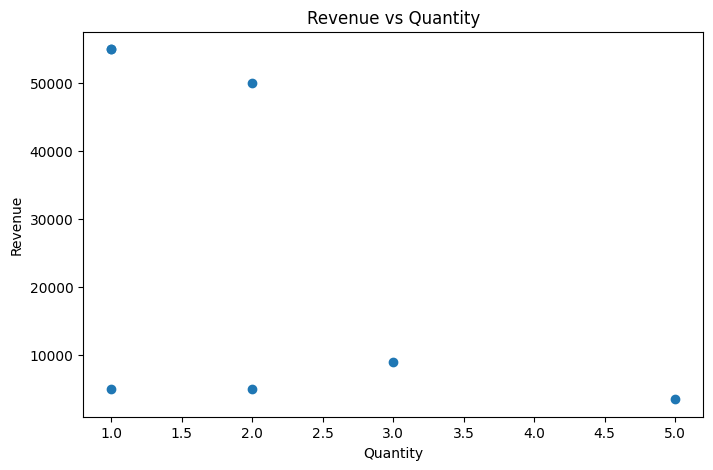

Notebook completed.


In [11]:
import matplotlib.pyplot as plt

pd_revenue_category = (orders_df.join(products_df, "product_id")
.groupBy("category").agg(F.sum(F.col("quantity")*F.col("price")).alias("revenue"))
.toPandas())
plt.figure(figsize=(8,5))
plt.bar(pd_revenue_category['category'], pd_revenue_category['revenue'])
plt.title('Revenue by Category')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.show()

pd_orders_month = orders_df.withColumn("month", F.substring("order_date",1,7)).groupBy("month").agg(F.count("order_id").alias("num_orders")).orderBy("month").toPandas()
plt.figure(figsize=(8,5))
plt.plot(pd_orders_month['month'], pd_orders_month['num_orders'], marker='o')
plt.title('Number of Orders per Month')
plt.xlabel('Month')
plt.ylabel('Orders')
plt.show()

pd_rev_qty = (orders_df.join(products_df,"product_id")
.withColumn("revenue",F.col("quantity")*F.col("price"))
.select("quantity","revenue").toPandas())
plt.figure(figsize=(8,5))
plt.scatter(pd_rev_qty['quantity'], pd_rev_qty['revenue'])
plt.title('Revenue vs Quantity')
plt.xlabel('Quantity')
plt.ylabel('Revenue')
plt.show()


print("Notebook completed.")